In [1]:
!module list

Currently Loaded Modulefiles:
 1) singularity   2) openmpi/4.1.5   3) NCI-ai-ml/24.08   4) pbs  
>

In [2]:
import scipy.stats as stats
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#import pyshtools as pysh
#pysh.utils.figstyle(rel_width=0.75)
#%config InlineBackend.figure_format = 'retina'

In [3]:
# prepare the autoregressive dataset
import sys
from torch.utils.data import DataLoader
nb_dir="/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes"
sys.path.append(nb_dir)
from datasets import WBDataset


ddir = "/g/data/wb00/admin/testing/t_WeatherBench"
dpth_str = f"{ddir}/wb2*.nc"
cpth = f"{ddir}/constants_1.40625deg.nc"
mpth = f"{ddir}/all_means.npy"
spth = f"{ddir}/all_stds.npy"
rpth = f"{ddir}/all_res.npy"
avs = list(np.load(f"{ddir}/ordering.npy"))
vs = ["tisr","t850","q850","u500","v500"] # add tp in the future
idx = [avs.index(vi) for vi in vs]
vc = ["lat2d","lon2d","lsm","orography"]
nsamples = 87600 # 10y hourly
samples = WBDataset(dpth_str,cpth,in_chans=vs, out_chans=vs, const_chans=vc, norm_paths=[mpth,spth],idx=idx, nsamples=nsamples)
#
# temperature: mean=277.4626770019531, std=17.816375732421875
# humidity: mean=0.006629979237914085, std=0.005532822106033564
# u_wind: mean=10.695755004882812, std=15.56001091003418
# v_wind: mean=-0.02342492900788784, std=12.149330139160156
# surface_pressure: mean=96811.390625, std=9123.89453125
# precipitation: mean=0.0006106931250542402, std=0.001604488817974925
# tisr: mean=1079093.125, std=1444145.25
# orography: mean=367.17120361328125, std=809.2915649414062
#

list(zip(vs, samples.means[:,0,0], samples.stds[:,0,0]))

[('tisr', 1074533.125, 453293.4375),
 ('t850', 274.5665588378906, 27.66683578491211),
 ('q850', 0.004556735977530479, 0.0013250404736027122),
 ('u500', 6.452450752258301, 4.8912739753723145),
 ('v500', -0.02425844967365265, 3.523120641708374)]

# Const Channels

In [4]:
# for log scale preciptation
samples.const_chans.shape

(4, 128, 256)

In [5]:
for ii in range(len(vc)):
    ti = samples.const_chans[ii,:,:]
    print(f"{vc[ii]}: min={ti.min()}, max={ti.max()}")

lat2d: min=0.0, max=1.0
lon2d: min=0.0, max=1.0
lsm: min=0.0, max=1.0
orography: min=0.0, max=1.0


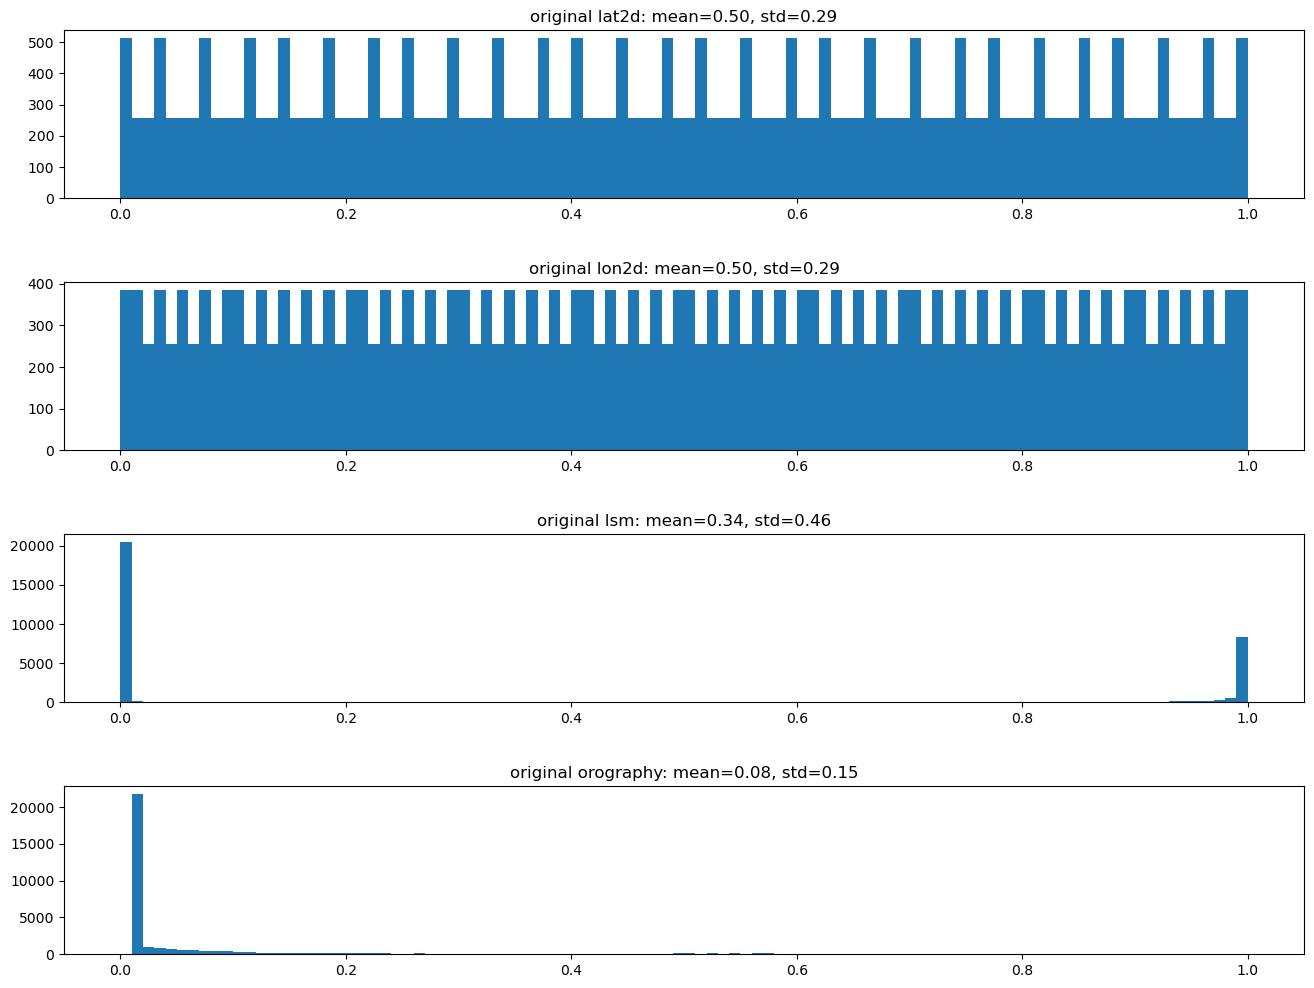

In [6]:
# plot the distribution of all variable fileds
vars_to_plot = vc
ss0 = []
ss1 = []
fig, axes = plt.subplots(len(vars_to_plot), 1, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):
    #print(var)
    data = samples.const_chans[ii,:,:].flatten()
    data = data[~np.isnan(data)]
 
    #axes[ii].hist(data, bins=100,density=True)
    axes[ii].hist(data, bins=100)
    axes[ii].set_title(f"original {var}: mean={data.mean():.2f}, std={data.std():.2f}")

    
plt.subplots_adjust(hspace=0.5)

# Variable Fields

In [ ]:
from dask.distributed import Client
client = Client(n_workers=20, threads_per_worker=1, processes=True);

In [ ]:
client

In [9]:
import pathlib
import xarray as xr
ddir = "/g/data/wb00/admin/testing/t_WeatherBench"
ss = pathlib.Path(ddir)
data_paths = sorted(list(ss.glob("wb2*.nc")))
ds = xr.open_mfdataset(data_paths, combine='by_coords',chunks="auto")
ds_in = ds[vs]
ds_in

<xarray.Dataset> Size: 57GB
Dimensions:  (time: 87672, lat: 128, lon: 256)
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 1kB -89.3 -87.89 -86.48 -85.08 ... 86.48 87.89 89.3
  * time     (time) datetime64[ns] 701kB 2000-01-01 ... 2009-12-31T23:00:00
Data variables:
    tisr     (time, lat, lon) float32 11GB dask.array<chunksize=(4327, 62, 125), meta=np.ndarray>
    t850     (time, lat, lon) float32 11GB dask.array<chunksize=(4327, 62, 125), meta=np.ndarray>
    q850     (time, lat, lon) float32 11GB dask.array<chunksize=(4327, 62, 125), meta=np.ndarray>
    u500     (time, lat, lon) float32 11GB dask.array<chunksize=(4327, 62, 125), meta=np.ndarray>
    v500     (time, lat, lon) float32 11GB dask.array<chunksize=(4327, 62, 125), meta=np.ndarray>

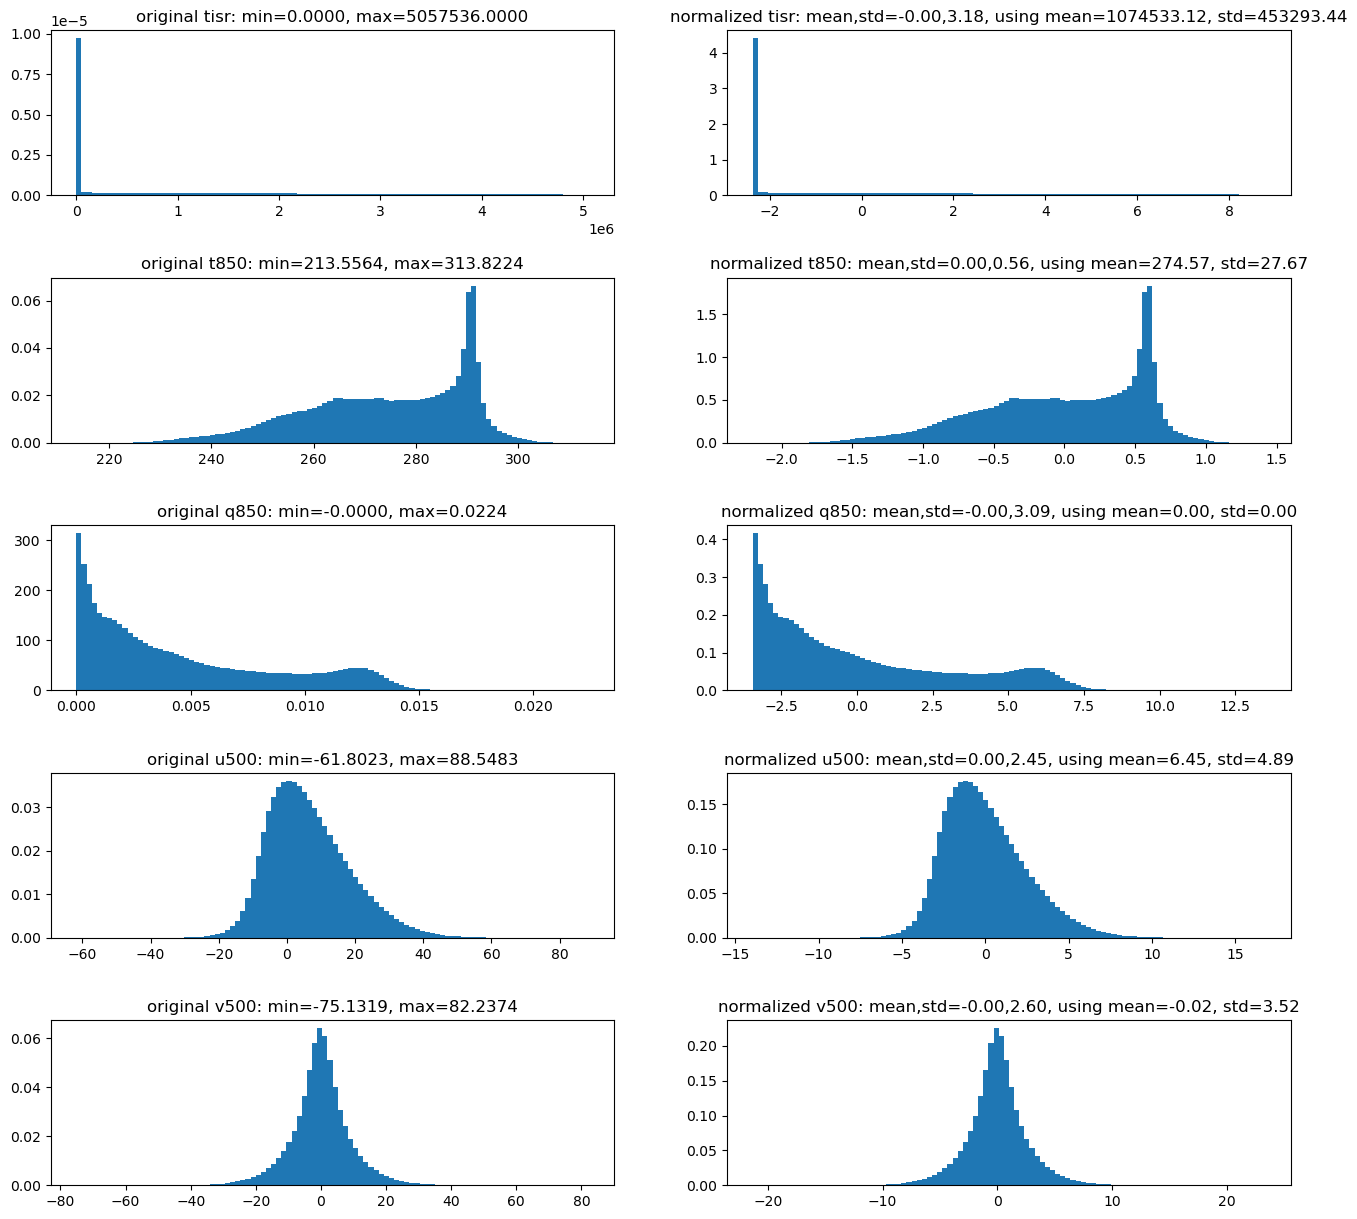

In [10]:
# plot the distribution of all variable fileds
vars_to_plot = vs
ss0 = []
ss1 = []
fig, axes = plt.subplots(len(vars_to_plot), 2, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

mmean = samples.means[:,0,0]
sstd = samples.stds[:,0,0]
for ii, var in enumerate(vars_to_plot):
    #print(var)
    data = ds_in[var].values.flatten()
    data = data[~np.isnan(data)]
    vmin = data.min()
    vmax = data.max()
    
    axes[ii, 0].hist(data, bins=100,density=True)
    axes[ii, 0].set_title(f"original {var}: min={vmin:.4f}, max={vmax:.4f}")

    idx = vs.index(var)
    data_norm = (data - mmean[idx]) / sstd[idx]
    ss0.append(data_norm.mean())
    ss1.append(data_norm.std())
    axes[ii, 1].hist(data_norm, bins=100, density=True)
    axes[ii, 1].set_title(f"normalized {var}: mean,std={ss0[ii]:.2f},{ss1[ii]:.2f}, using mean={mmean[idx]:.2f}, std={sstd[idx]:.2f}")

plt.subplots_adjust(hspace=0.5)

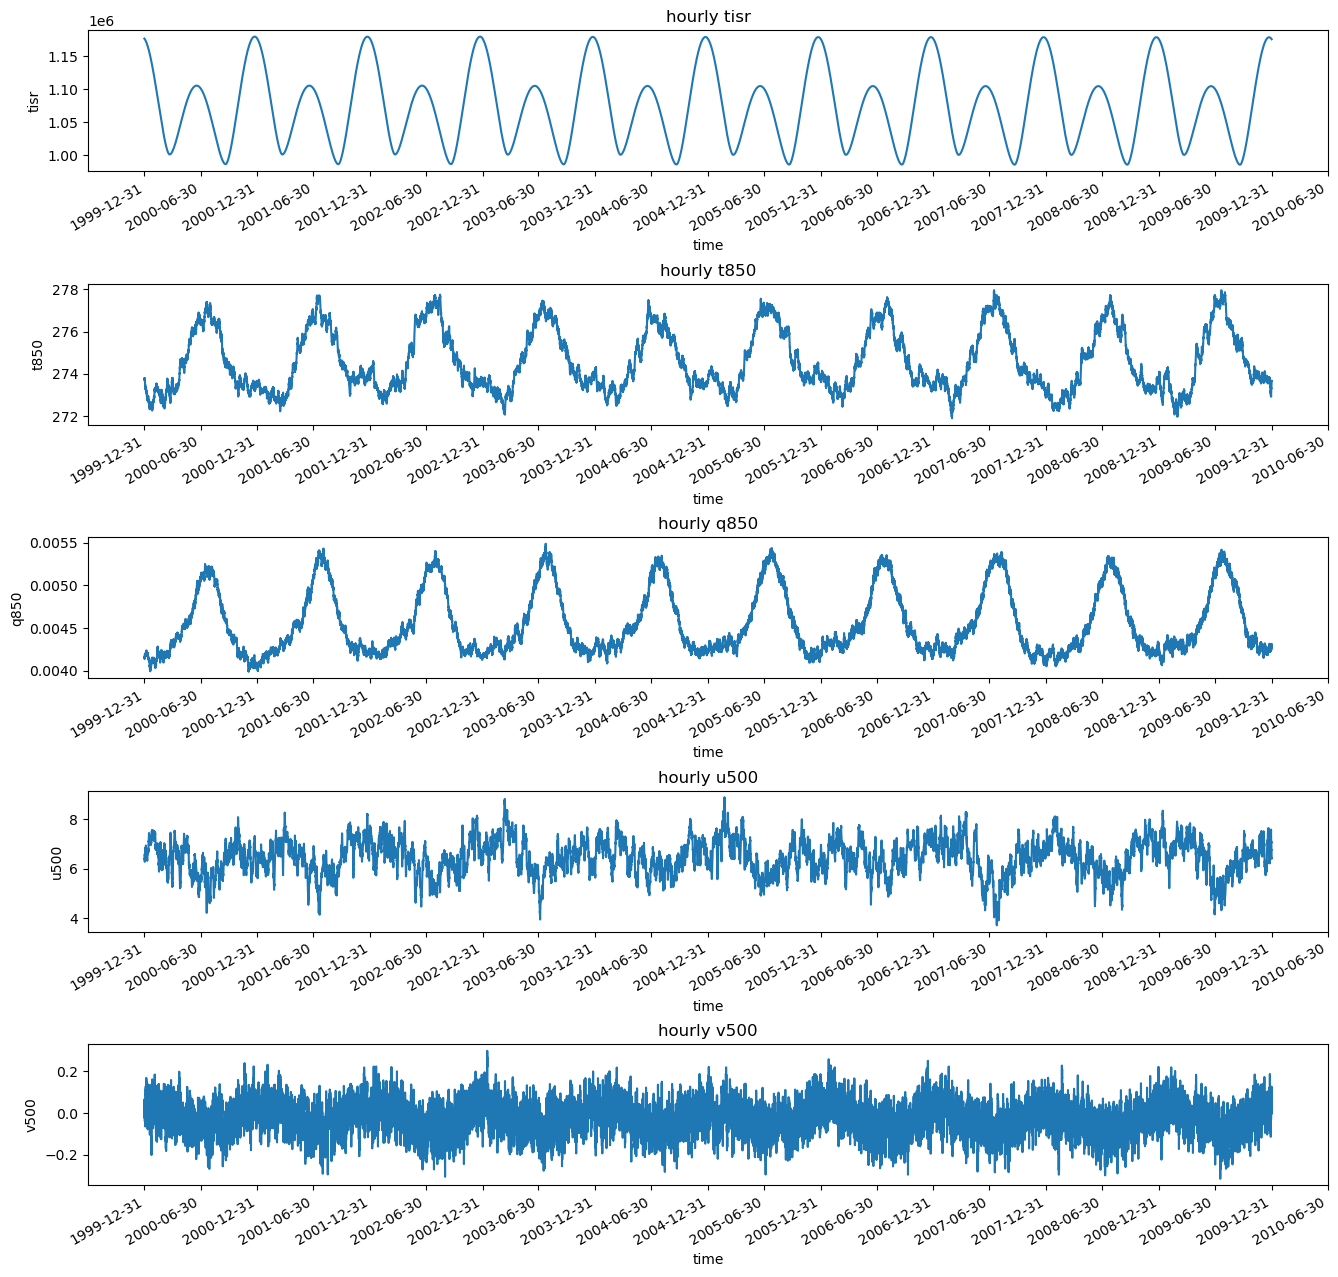

In [11]:
# plot the global mean over time of each variable
import matplotlib.dates as mdates
fig, axes = plt.subplots(len(vars_to_plot), 1, figsize=(16, 3 * len(vars_to_plot)))
if len(vars_to_plot) == 1:
    axes = [axes] 

for ii, var in enumerate(vars_to_plot):

    data = ds_in[var].mean(dim=('lat', 'lon'))
    data.plot(ax=axes[ii])
    axes[ii].set_title(f"hourly {var}")
    axes[ii].xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,7]))
    axes[ii].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    for label in axes[ii].get_xticklabels():
        label.set_rotation(30)
        label.set_ha('right')
    
plt.subplots_adjust(hspace=0.8)

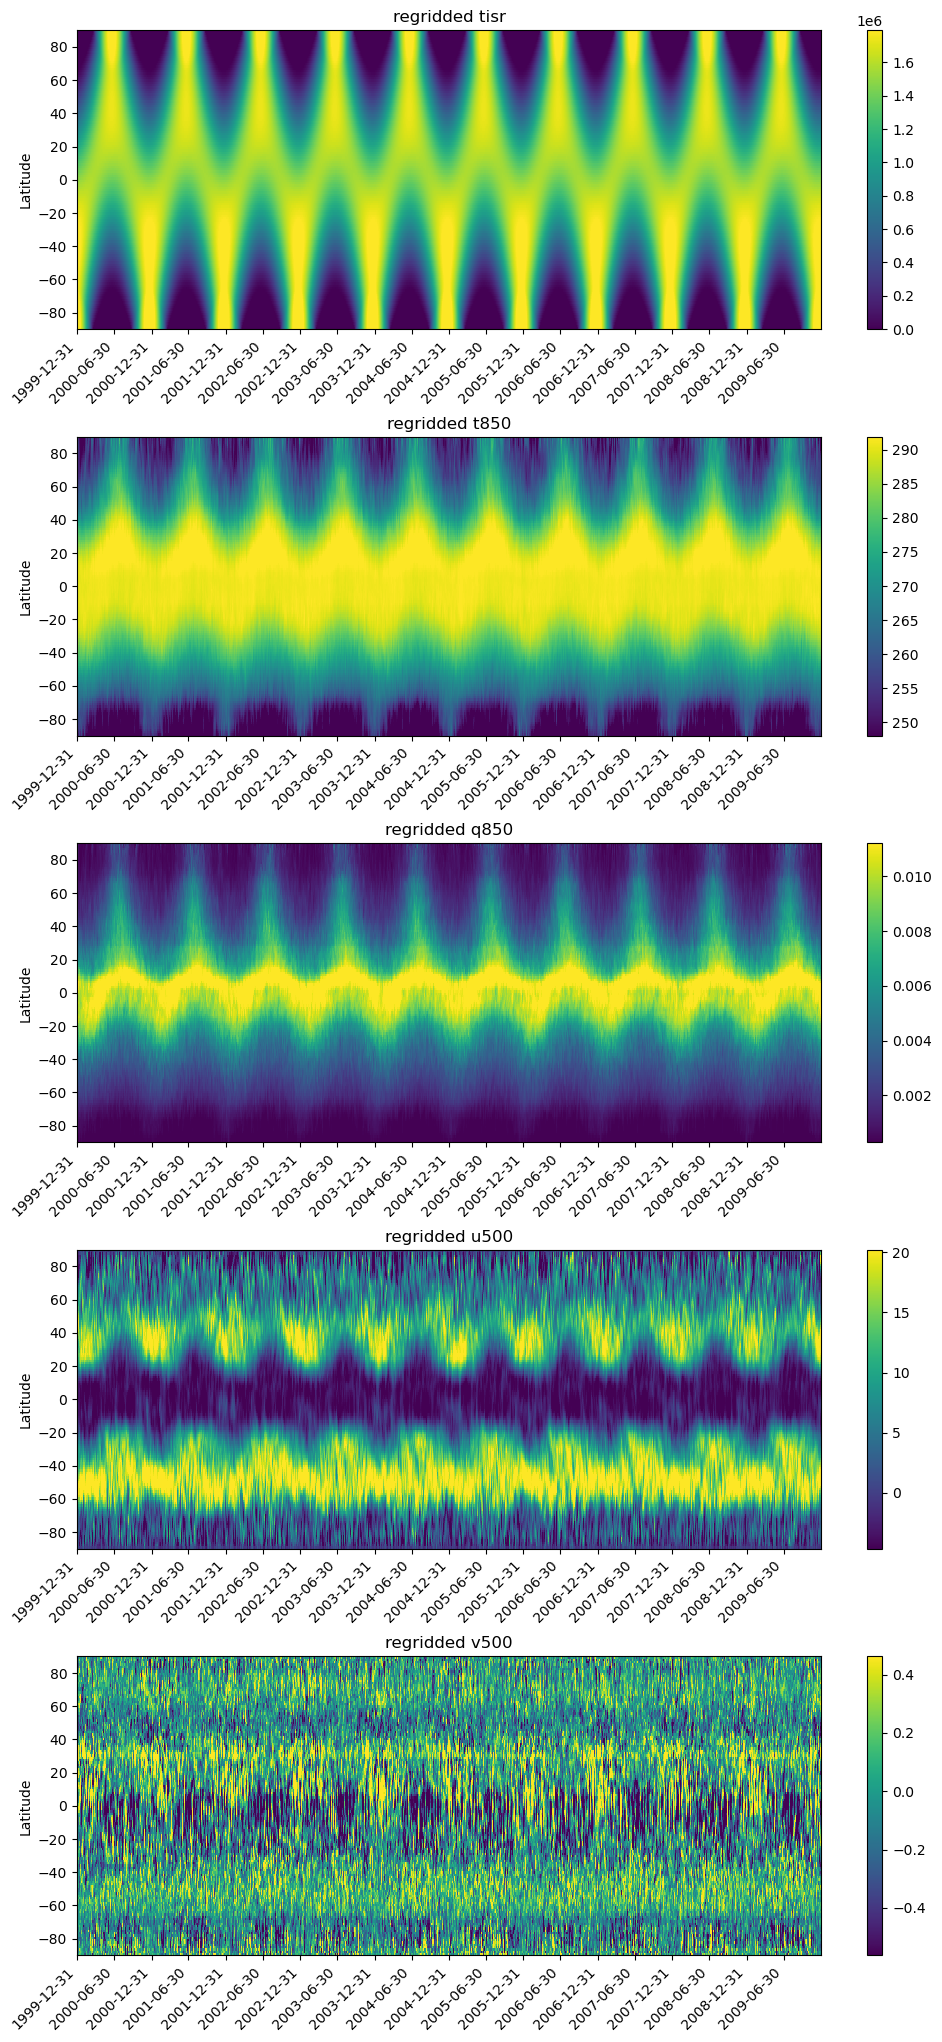

In [12]:
# plot the lat-mean over time 
fig, axes = plt.subplots(len(vs), 1, figsize=(12, 5*len(vs)),squeeze=False)
for ii, var in enumerate(vs):
    data = ds_in[var].mean(dim=('lon'))
    cmin, cmax = np.nanquantile(data.values.flatten(), [0.05, 0.95])
    
    ax = axes[ii,0]
    im0 = ax.pcolormesh(data.time, data.lat, data.T, vmin=cmin, vmax=cmax, cmap='viridis', shading='auto')
    ax.set_ylabel('Latitude')
    ax.set_title(f'regridded {var}')
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,7]))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    fig.colorbar(im0, ax=ax)
    
plt.subplots_adjust(hspace=0.36)
plt.show()

# The END